In [1]:
# логистическая регрессия

import pandas as pd                                         # для работы с датафреймом
import numpy as np                                          # для вычислений
import seaborn as sns                                       # для графиков
import matplotlib.pyplot as plt                             # для графиков

from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split        # для деления на обучающую и тестовую выборки
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Данные

In [2]:
# загружаем данные и исправляем тип данных
db = pd.read_csv('data/books_tidy_data.csv', parse_dates=['publication_date'], dtype={'decade':'object', 'quarter':'object', 'tra_co':'object'})

In [3]:
# удалим признаки, которые не будем рассматривать в данном исследовании
db = db.drop(['title', 'publication_date', 'authors', 'language_code', 'publisher'], axis=1)

In [4]:
db.head()

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co
0,4.57,652,2095690,27591,2000,3,1
1,4.49,870,2153167,29221,2000,3,1
2,4.42,352,6333,244,2000,4,0
3,4.56,435,2339585,36325,2000,2,1
4,4.78,2690,41428,164,2000,3,1


In [5]:
db.describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,10838.000000,10838.000000,1.083800e+04,10838.000000
mean,3.942158,344.175217,1.834788e+04,553.074737
std,0.295387,238.556381,1.138660e+05,2599.330244
min,1.000000,11.000000,0.000000e+00,0.000000
25%,3.770000,203.000000,1.170000e+02,10.000000
50%,3.960000,304.000000,8.035000e+02,49.000000
75%,4.130000,417.000000,5.226750e+03,248.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000


<AxesSubplot:xlabel='num_pages', ylabel='average_rating'>

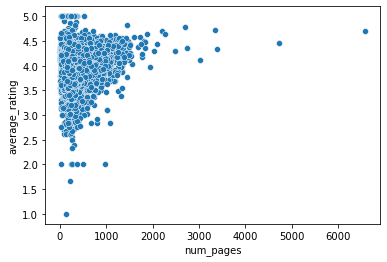

In [6]:
sns.scatterplot(x='num_pages', y='average_rating', data=db)

На основе предыдущих исследований количество страниц самый перспективный признак, на графике видно, что явно имеются выбросы. Среднее составляет 3.94 со стандартным отклонением 0.3. Мы будем решать задачу бинарной классификации, когда 0 - это плохие оценки (1,2,3), а 1 - хорошие, то есть 4 и 5.

In [7]:
bins = [0, 4, 5]            # группы, на которые мы разобьем среднюю оценку
groups_names = ['0', '1']   # название этих групп
db['rating_groups'] = pd.cut(db['average_rating'], bins, labels=groups_names, right=True).astype('int64') # проводим разбиение на группы
db = db.drop(['average_rating'], axis=1) # удаляем количественный признак, на основании которого построили бинарный

In [8]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10838 entries, 0 to 10837
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   num_pages           10838 non-null  int64 
 1   ratings_count       10838 non-null  int64 
 2   text_reviews_count  10838 non-null  int64 
 3   decade              10838 non-null  object
 4   quarter             10838 non-null  object
 5   tra_co              10838 non-null  object
 6   rating_groups       10838 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 592.8+ KB


In [9]:
db.head()

,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,rating_groups
0,652,2095690,27591,2000,3,1,1
1,870,2153167,29221,2000,3,1,1
2,352,6333,244,2000,4,0,1
3,435,2339585,36325,2000,2,1,1
4,2690,41428,164,2000,3,1,1


Проверим, сколько наблюдений содержит каждый класс.

In [10]:
db['rating_groups'].value_counts(normalize=True)

0    0.574276
1    0.425724
Name: rating_groups, dtype: float64

Видим, что классы значительно различаются по количеству наблюдений. Следовательно, нужно будет решать задачу по дисбалансу классов.  

Мы будем использовать три подхода: 1) визуальный, 2) статистический, 3) машинное обучение. Визуализировать данные необходимо, так как именно визуально легче схватить какие-то значимые характеристики распределения данных (если данные это позволяют). Статистический подход необходим, чтобы понимать, как работает логистическая регрессия "под капотом". Машинное обучение позволяет проводить множество различных манипуляций с данными для улучшения модели предсказания.

Важно понимать разницу межу чисто статистическим подходом и машинным обучением. Для статистического подхода не требуется разделять данные на тренировочный и тестовый наборы.  

Мы применим большинство подходов, о которых упоминается в учебниках.